# <u> Финальный проект: Karpov.Courses </u>
<hr>

## Задание 1. A/B–тестирование

### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных имеется 4 csv-файла:

<li> <b>groups.csv</b> - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
<li> <b>groups_add.csv</b> - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
<li> <b>active_studs.csv</b> - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
<li> <b>checks.csv</b> - файл с информацией об оплатах пользователей в дни проведения эксперимента. <p>

### 1.3 Вопросы для рассмотрения:

1. На какие метрики Вы смотрите в ходе анализа и почему?
2. Имеются ли различия в показателях и с чем они могут быть связаны?
3. Стоит ли запускать новую механику на всех пользователей?
4. Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

### 1.4 Требования к ответу

При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

### Подготовка данных

In [73]:
# Загружаем необходимые библиотеки и модули
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, chi2_contingency
from math import sqrt
import requests
from urllib.parse import urlencode
from tqdm.auto import tqdm
import pandahouse as ph
import datetime
import time

In [2]:
# загружаем данные
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# ссылки на данные с указанием разделителя csv-файла
links_dic = {
    'groups':       ['https://disk.yandex.ru/d/UhyYx41rTt3clQ', ';'],
    'groups_add':   ['https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', ','],
    'active_studs': ['https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', ','],
    'checks':       ['https://disk.yandex.ru/d/pH1q-VqcxXjsVA', ';']
            }

# скачиваем файлы
for csv_filename, csv_link in links_dic.items():
    final_url               = base_url + urlencode(dict(public_key=csv_link[0]))
    response                = requests.get(final_url)
    download_url            = response.json()['href']
    globals()[csv_filename] = pd.read_csv(download_url, sep=csv_link[1])

In [3]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [4]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [5]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [6]:
# переименуем student_id в id для удобства (так все таблицы будут иметь одинаковое наименование id пользователей)
active_studs=active_studs.rename(columns={'student_id': 'id'})
checks=checks.rename(columns={'student_id': 'id'})

In [7]:
active_studs.head()

,id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [8]:
checks.head()

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


### Исследование данных

In [9]:
# Размер таблиц
print(f'Размер groups     {groups.shape}')
print(f'Размер groups_add     {groups_add.shape}')
print(f'Размер active_studs   {active_studs.shape}')
print(f'Размер checks         {checks.shape}')

Размер groups     (74484, 2)
Размер groups_add     (92, 2)
Размер active_studs   (8341, 1)
Размер checks         (541, 2)


In [10]:
# Т.к. groups_add является дополнением groups, то соединим их и получим общую таблицу со всеми пользователями и их группами
groups_all = pd.concat([groups, groups_add])
groups_all

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [11]:
print(f'Размер таблицы всех пользователей:{groups_all.shape}')

Размер таблицы всех пользователей:(74576, 2)


In [12]:
# По таблице видим распределение по группа A и B. Посмотрим как именно распределены пользователи (id).
print(f'Распределение всех пользователей по группам: \nГруппа A: {groups_all.grp.value_counts()[1]} \nГруппа B: {groups_all.grp.value_counts()[0]} \nВсего: {groups_all.grp.value_counts()[1] +groups_all.grp.value_counts()[0]}')

Распределение всех пользователей по группам: 
Группа A: 14693 
Группа B: 59883 
Всего: 74576


Отметим, что группы распределены неравнозначно. Число id в группе B намного превышает группу A. 

In [13]:
groups_all.duplicated().sum()

0

In [14]:
groups_all.nunique()

id     74576
grp        2
dtype: int64

Дубликатов нет, все пользователи уникальны.<br>
#### Рассмотрим список активных пользователей и оплативших:

In [15]:
paid_not_active = checks.query('id not in @active_studs.id')
print('Количество пользователей из списка активных, но не вошедших в общий список:', 
      active_studs.query('id not in @groups_all.id').shape[0],
      '\nКоличество оплативших пользователей, отсутствующих в общем списке:',
      checks.query('id not in @groups_all.id').shape[0],
      '\nКоличество оплативших пользователей, отсутствующих в списке активных в дни проведения теста:',
      paid_not_active.shape[0])

Количество пользователей из списка активных, но не вошедших в общий список: 0 
Количество оплативших пользователей, отсутствующих в общем списке: 0 
Количество оплативших пользователей, отсутствующих в списке активных в дни проведения теста: 149


Странный момент: присутствуют пользователи с оплатой, но которые не были активны в дни проведения теста. Это может быть либо ошибка, либо вариант автоплатежа. Посмотрим как в таком случаи неактивные оплатившие будут распределены по группам

In [16]:
print('Оплатили, но не в списке активных, количество по группам:\nГруппа A:', 
      groups_all.query('id in @paid_not_active.id').grp.value_counts()[1], '\nГруппа B:',
      groups_all.query('id in @paid_not_active.id').grp.value_counts()[0])

Оплатили, но не в списке активных, количество по группам:
Группа A: 29 
Группа B: 120


К сожалению по имеющимся данным нет возможности уточнить ситуацию с оплатившими, но неактивными пользователями, поэтому отметим этот момент и пойдем дальше.<br>
Рассмотрим остальные случаи

In [17]:
print('Активные оплатившие пользователи, количество по группам: \nГруппа A:', 
     groups_all.query('id in @active_studs.id & id in @checks.id').grp.value_counts()[1], '\nГруппа B:',
      groups_all.query('id in @active_studs.id & id in @checks.id').grp.value_counts()[0], '\nВсего:   ',
      groups_all.query('id in @active_studs.id & id in @checks.id').grp.value_counts()[1] +
      groups_all.query('id in @active_studs.id & id in @checks.id').grp.value_counts()[0])

Активные оплатившие пользователи, количество по группам: 
Группа A: 78 
Группа B: 314 
Всего:    392


In [18]:
print('Активные, но не оплатившие пользователи, количество по группам: \nГруппа A:', 
      groups_all.query('id in @active_studs.id & id not in @checks.id').grp.value_counts()[1], '\nГруппа B:',
      groups_all.query('id in @active_studs.id & id not in @checks.id').grp.value_counts()[0], '\nВсего:   ',
      groups_all.query('id in @active_studs.id & id not in @checks.id').grp.value_counts()[1] +
      groups_all.query('id in @active_studs.id & id not in @checks.id').grp.value_counts()[0])

Активные, но не оплатившие пользователи, количество по группам: 
Группа A: 1460 
Группа B: 6489 
Всего:    7949


Сведем все рассмотренные данные

In [19]:
# Объединим список активных пользователей со списком оплативших, отбросив из последних тех, кого нет в списке активных:
active_checks = active_studs.merge(checks, how='left', on='id')
active_checks

,id,rev
0,581585,NaN
1,5723133,NaN
2,3276743,NaN
3,4238589,NaN
4,4475369,NaN
...,...,...
8336,1794344,NaN
8337,296883,NaN
8338,3598448,NaN
8339,3610547,290.0


In [20]:
# Объединим активных оплативших из предыдущего шага с groups_all, оставив только активных:
active_all = active_checks.merge(groups_all, how='left', on='id')
active_checks

,id,rev
0,581585,NaN
1,5723133,NaN
2,3276743,NaN
3,4238589,NaN
4,4475369,NaN
...,...,...
8336,1794344,NaN
8337,296883,NaN
8338,3598448,NaN
8339,3610547,290.0


In [21]:
# Добавим колонку со статусом оплаты (0 - не оплачен, 1 - оплачен):
active_all['payment'] = active_all.rev.apply(lambda x: 0 if np.isnan(x) else 1)
active_all.query('rev.isna()').head()

,id,rev,grp,payment
0,581585,NaN,A,0
1,5723133,NaN,A,0
2,3276743,NaN,B,0
3,4238589,NaN,A,0
4,4475369,NaN,B,0


In [22]:
# Заменим Nan на 0
active_all['rev'] = active_all.rev.fillna(0)
active_all

,id,rev,grp,payment
0,581585,0.0,A,0
1,5723133,0.0,A,0
2,3276743,0.0,B,0
3,4238589,0.0,A,0
4,4475369,0.0,B,0
...,...,...,...,...
8336,1794344,0.0,B,0
8337,296883,0.0,B,0
8338,3598448,0.0,B,0
8339,3610547,290.0,B,1


Разобьем активных на группы

In [23]:
# группа А
a_group=active_all.query('grp=="A"')
a_group

,id,rev,grp,payment
0,581585,0.0,A,0
1,5723133,0.0,A,0
3,4238589,0.0,A,0
7,1394612,0.0,A,0
21,5194768,0.0,A,0
...,...,...,...,...
8317,3208984,0.0,A,0
8320,2900558,0.0,A,0
8326,1161774,0.0,A,0
8330,5006972,0.0,A,0


In [24]:
# группа B
b_group=active_all.query('grp=="B"')
b_group

,id,rev,grp,payment
2,3276743,0.0,B,0
4,4475369,0.0,B,0
5,5481015,0.0,B,0
6,1353433,0.0,B,0
8,1170611,0.0,B,0
...,...,...,...,...
8336,1794344,0.0,B,0
8337,296883,0.0,B,0
8338,3598448,0.0,B,0
8339,3610547,290.0,B,1


In [25]:
# Активные и оплатившие
active_paid=active_all.query('rev>0')
active_paid

,id,rev,grp,payment
62,1184303,1530.0000,A,1
67,3354191,1900.0001,B,1
77,3278734,1900.0000,B,1
99,720651,1980.0000,A,1
193,1232221,1900.0000,B,1
...,...,...,...,...
8201,3890326,199.0000,B,1
8204,1390994,398.0000,A,1
8263,1516339,290.0000,A,1
8277,3910596,597.0000,B,1


In [26]:
# Активные и оплатившие в группе А
a_group_paid=a_group.query('payment==1')
a_group_paid

,id,rev,grp,payment
62,1184303,1530.0,A,1
99,720651,1980.0,A,1
306,4337103,580.0,A,1
392,332387,2910.0,A,1
439,1659434,690.0,A,1
...,...,...,...,...
7950,445767,3660.0,A,1
8025,1202202,2910.0,A,1
8027,2306271,290.0,A,1
8204,1390994,398.0,A,1


In [27]:
# Активные и оплaтившие в группе B
b_group_paid=b_group.query('payment==1')
b_group_paid

,id,rev,grp,payment
67,3354191,1900.0001,B,1
77,3278734,1900.0000,B,1
193,1232221,1900.0000,B,1
195,3821501,1900.0000,B,1
211,1036096,1900.0000,B,1
...,...,...,...,...
8109,2692209,1900.0001,B,1
8191,2081846,1900.0000,B,1
8201,3890326,199.0000,B,1
8277,3910596,597.0000,B,1


In [28]:
# Активные и не оплатившие
active_not_paid=active_all.query('rev==0')
active_not_paid

,id,rev,grp,payment
0,581585,0.0,A,0
1,5723133,0.0,A,0
2,3276743,0.0,B,0
3,4238589,0.0,A,0
4,4475369,0.0,B,0
...,...,...,...,...
8335,264371,0.0,B,0
8336,1794344,0.0,B,0
8337,296883,0.0,B,0
8338,3598448,0.0,B,0


In [29]:
# Активные и не оплатившие в группе А
a_group_not_paid=a_group.query('payment==0')
a_group_not_paid

,id,rev,grp,payment
0,581585,0.0,A,0
1,5723133,0.0,A,0
3,4238589,0.0,A,0
7,1394612,0.0,A,0
21,5194768,0.0,A,0
...,...,...,...,...
8317,3208984,0.0,A,0
8320,2900558,0.0,A,0
8326,1161774,0.0,A,0
8330,5006972,0.0,A,0


In [30]:
# Активные и не оплатившие в группе B
b_group_not_paid=b_group.query('payment==0')
b_group_not_paid

,id,rev,grp,payment
2,3276743,0.0,B,0
4,4475369,0.0,B,0
5,5481015,0.0,B,0
6,1353433,0.0,B,0
8,1170611,0.0,B,0
...,...,...,...,...
8335,264371,0.0,B,0
8336,1794344,0.0,B,0
8337,296883,0.0,B,0
8338,3598448,0.0,B,0


### Построим распределения по группам и посмотрим информацию для определения метрик

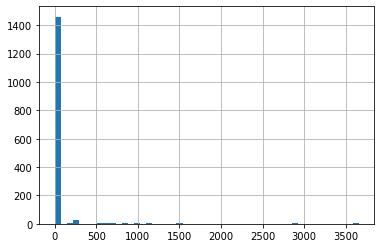

In [31]:
# Распределение А группы
a_group.rev.hist(bins=50)

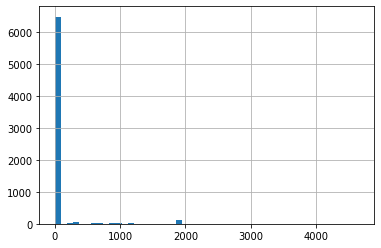

In [32]:
# Распределение B группы
b_group.rev.hist(bins=50)

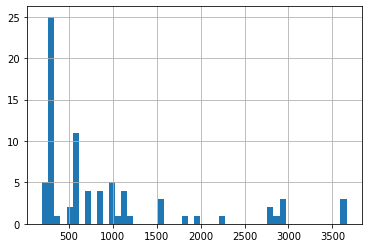

In [33]:
# Распределение А группы оплативших
a_group_paid.rev.hist(bins=50)

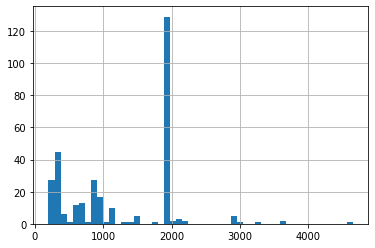

In [34]:
# Распределение B группы оплативших
b_group_paid.rev.hist(bins=50)

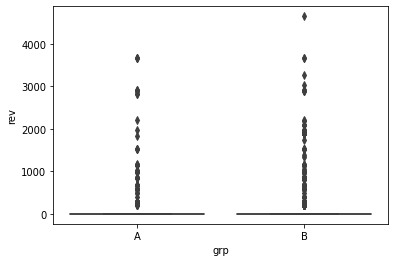

In [35]:
# Посмотрим на выбросы активных
sns.boxplot(data=active_all, y='rev', x='grp')

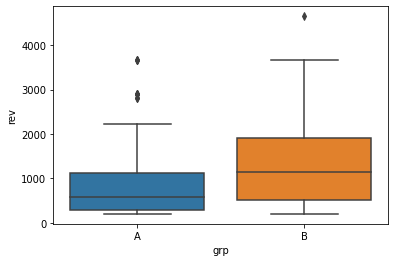

In [36]:
# Посмотрим на выбросы активных оплативших
sns.boxplot(data=active_paid, y='rev', x='grp')

Рассмотрим описательные характеристики по группам

In [37]:
# Активные
a_group_info = a_group.rev.describe().to_frame().rename(columns={'rev': 'Группа А'})
b_group_info = b_group.rev.describe().to_frame().rename(columns={'rev': 'Группа В'})
pd.concat([a_group_info, b_group_info], axis=1)

,Группа А,Группа В
count,1538.000000,6803.000000
mean,47.347204,58.058798
std,290.490632,313.770201
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,3660.000000,4650.000000


In [38]:
# Активные и оплатившие
a_group_paid_info = a_group_paid.rev.describe().to_frame().rename(columns={'rev': 'Группа А'})
b_group_paid_info = b_group_paid.rev.describe().to_frame().rename(columns={'rev': 'Группа В'})
pd.concat([a_group_paid_info, b_group_paid_info], axis=1)

,Группа А,Группа В
count,78.000000,314.000000
mean,933.589744,1257.878992
std,919.932711,790.864254
min,199.000000,199.000000
25%,290.000000,511.750000
50%,585.000000,1140.000000
75%,1114.750000,1900.000000
max,3660.000000,4650.000000


Проведя исследования представленных данных, можно подвести итог: <br>
Среди пользователей есть те пользователи, что заходили на сайт в дни теста - активные и те, кто произвели оплату. Активные пользователи могли совершить платеж, однако среди данных были обнаружены пользователи, что не были активными, но факт оплаты был. Это могли быть автоплатежи или же ошибка. Понять нет возможности, поэтому отложили их в сторону. 
Из распределения активных пользователей по группа отметим их неравномерность (группа B численно больше, чем группа A). 

После изучения распределений и описательной статистики по группам выберем метрики для проверки.<br>
<li>Для рассмотрения отношения количества оплативших пользователей к общему числу активных пользователей выберем метрику <b> CR </b>, т.е. проверим на сколько отличается коэффициент конверсии между группами при переходе от активных к активным и оплатившим. Там где CR будет выше, там будет преимущество при оплате.
<li>Наличие оплаты делает важным показатель средней выручки с одного платящего пользователя, т.е. отношение общей суммы на количество активных оплативших пользователей. Поэтому также выбераем метрику <b> ARPPU </b>.
<li>Аналогично для рассмотрения какая группа приносит больше денег выберем отношение общей суммы на количество активных пользователей, т.е. метрику <b> ARPU </b>. В данном случае среднее значение является показателем метрики (средняя выручка с одного платящего пользователя).<br>
Т.к. рассматриваем новую механику оплаты, то метрики рассматриваем по группам оплативших.

### Рассчитаем выбранные метрики

In [39]:
CR_A=round(a_group_paid.id.count() / a_group.id.count(), 3)
CR_B=round(b_group_paid.id.count() / b_group.id.count(), 3)
print(f'CR: \nГруппа А: {CR_A} \nГруппа B: {CR_B}')
# Конверсия группы B относительно группы А
CR=round((round(b_group_paid.id.count() / b_group.id.count(), 3) - round(a_group_paid.id.count() / a_group.id.count(), 3)) / 
      round(a_group_paid.id.count() / a_group.id.count(), 3), 3) * 100
if CR>0:
    print(f'Конверсия группы A больше группы B на {CR}%')
else:
    print(f'Конверсия группы B больше группы A на {abs(CR)}%')

CR: 
Группа А: 0.051 
Группа B: 0.046
Конверсия группы B больше группы A на 9.8%


In [40]:
ARPU_A=round(a_group_paid.rev.sum() / a_group.id.count(), 2)
ARPU_B=round(b_group_paid.rev.sum() / b_group.id.count(), 2)
print(f'ARPU: \nГруппа А: {ARPU_A} \nГруппа B: {ARPU_B}')

ARPU=round((round(b_group_paid.rev.sum() / b_group.id.count(), 2) - round(a_group_paid.rev.sum() / a_group.id.count(), 2)) /
      round(a_group_paid.rev.sum() / a_group.id.count(), 2), 2)*100
if ARPU>0:
    print(f'ARPU группы B больше группы A на {ARPU}%')
else:
    print(f'ARPU группы A больше группы B на {abs(ARPU)}%')

ARPU: 
Группа А: 47.35 
Группа B: 58.06
ARPU группы B больше группы A на 23.0%


In [41]:
ARPPU_A=round(a_group_paid.rev.mean(), 2)
ARPPU_B=round(b_group_paid.rev.mean(), 2)
print(f'ARPPU: \nГруппа А: {ARPPU_A} \nГруппа B: {ARPPU_B}')

ARPPU=round(round(b_group_paid.rev.mean() - a_group_paid.rev.mean(), 2) / round(a_group_paid.rev.mean(), 2), 2) * 100
if ARPPU>0:
    print(f'ARPPU группы B больше группы A на {ARPPU}%')
else:
    print(f'ARPPU группы A больше группы B на {abs(ARPPU)}%')

ARPPU: 
Группа А: 933.59 
Группа B: 1257.88
ARPPU группы B больше группы A на 35.0%


### Имеются ли различия в показателях и с чем они могут быть связаны?
Наблюдаем отрицательный эффект CR, и положительные эффекты в ARPU и ARPPU. Т.е. конверсия падает, но доход на пользователя растёт. Это может быть связано c тем, что средний чек растет, а часть пользователей, платящие малые суммы отсекается.

### Являются ли эти различия статистически значимыми?

In [42]:
# Функция для bootstrap
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it=1000,
    statistic=np.mean,
    bootstrap_conf_level=0.95
):
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}

### CR
Для рассмотрения конверсии воспользуемся методом хи-квадрат, т.к. можем считать конверсию категориальной переменной

H0: Взаимосвязи между группой и статусом оплаты нет <br>
H1: Взаимосвязь между группой и статусом есть

In [71]:
# Таблица сопряженности: встречаемость
crosstab_table = pd.crosstab(active_all.grp, active_all.payment)

# Таблица сопряженности: проценты по всему
crosstab_table_percentage = round(pd.crosstab(active_all.grp,
                                              active_all.payment,
                                              normalize='all'),2)

# Хи-тест
c, p, dof, expected = chi2_contingency(crosstab_table)
print('Результат хи-теста: \n', 'chi_value:', c, '  df:', dof,'  p-value:', p)

Результат хи-теста: 
 chi_value: 0.48480826522557896   df: 1   p-value: 0.48625240457231045


Таким образом, результат хи-теста показал:
p_value: 0.48 отклоняем альтернативную гипотезу H1: взаимосвязи между Статусом и Группой нет

Следующие метрики будем рассматривать методом bootstrap. Отдельно также посмотрим CR методом bootstrap, чтобы подтвердить или опровергнуть ранее полученный результат.

Для рассмотрения статистической значимости выберем метод bootstrap.

Сформулируем нулевую и альтернативную гипотезы:

<li> H0: CR в двух группах одинаковые.
<li> H1: CR в двух группах различаются.

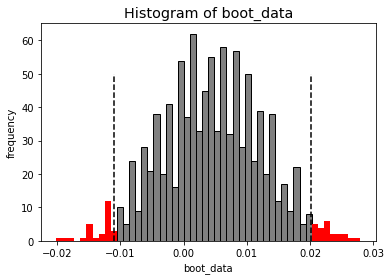

{'quants':               0
 0.025 -0.011053
 0.975  0.020156,
 'p_value': 0.5706231995466335}

In [43]:
get_bootstrap(a_group.payment, b_group.payment, statistic = np.mean)

В доверительный интервал попадает нулевое значение разницы между средними двух групп.

p-value > 0.05 говорит о том, что при условии верности нулевой гипотезы о равенстве средних в двух группах вероятность получить такое или еще большее отклонение разницы между средними бутстрап-выборок от 0 составляет более 5%. Значит, мы не имеем весомых оснований отвергнуть нулевую гипотезу.
Нельзя утверждать, что различия CR в двух группах есть. Поэтому можно сказать, что ранее рассчитанное отрицательное значения CR не подтвердилось.

### ARPPU
Сформулируем нулевую и альтернативную гипотезы:

<li> H0: ARPPU в двух группах одинаковые.
<li> H1: ARPPU в двух группах различаются.

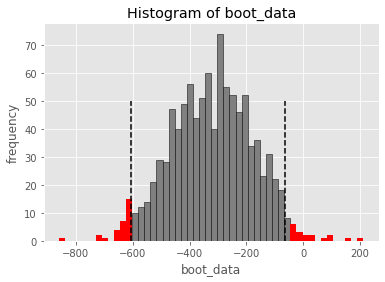

{'quants':                 0
 0.025 -605.289759
 0.975  -63.215071,
 'p_value': 0.02465976827232559}

In [44]:
get_bootstrap(a_group.rev[a_group.rev > 0], b_group.rev[b_group.rev > 0], statistic = np.mean)

Доверительный интервал не попадает в 0, можем отвергнуть нулевую гипотезу. ARPPU в двух группах различаются.

### ARPU
Сформулируем нулевую и альтернативную гипотезы:

<li> H0: ARPU в двух группах одинаковые.
<li> H1: ARPU в двух группах различаются.

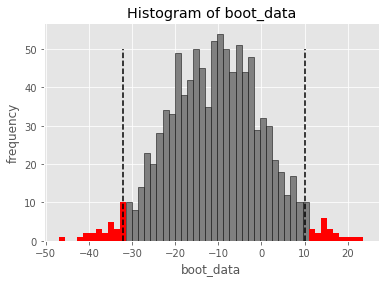

{'quants':                0
 0.025 -32.088427
 0.975   9.990946,
 'p_value': 0.32241623057826296}

In [45]:
get_bootstrap(a_group.rev, b_group.rev, statistic = np.mean)

Доверительный интервал не попадает в 0, можем отвергнуть нулевую гипотезу. ARPU в двух группах различаются.

### Стоит ли запускать новую механику на всех пользователей?
Новую механику оплату можно запускать, т.к. она дает статистически значимый прирост в метриках ARPU и ARPPU, отрицательное изменение метрики CR хоть и замечено, но не подтвердилось. <br>
В качестве рекомендаций стоит следить за CR. Возможно в дальнейшем эта метрика проявит себя лучше.

# Задание 2. SQL

## 2.1 Очень усердные ученики.

### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

### 2.1.2 Задача

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

NB! Под очень усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [46]:
# Объявляем параметры подключения к clickhouse
connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')

In [47]:
# При рассмотрении данных было замечено, что данных представлено всего за два дня
# Чтобы показать это был составлен следующий запрос:
query_min_max = """
SELECT
    MIN(toStartOfDay(timest)) AS min_data,
    MAX(toStartOfDay(timest)) AS max_data
FROM peas
"""
min_max = ph.read_clickhouse(query_min_max, connection=connection)
min_max

,min_data,max_data
0,2021-10-30,2021-10-31


По заданию необходимо назвать усердных студентов за текущий месяц, однако как отмечено выше данные представлены только за 2 дня в октябре 2021 года. За текущий месяц данных нет. Однако рассмотрим запрос о  нахождении очень усердных студентов за последний месяц.

In [48]:
# Количество очень усердных студентов за последний месяц
query_count_hw_st = """
SELECT
  COUNT(DISTINCT st_id) AS hardworking_students
FROM
  (
    SELECT st_id, 
    SUM(correct)
    FROM peas
    GROUP BY st_id
    HAVING SUM(correct)>=20 AND toStartOfMonth(timest)
        IN (SELECT 
                toStartOfMonth(MAX(timest))
            FROM peas)
  )

"""
count_hw_st = ph.read_clickhouse(query_count_hw_st, connection=connection)
print("Количество очень усердных студентов:", count_hw_st.iat[0, 0])

Количество очень усердных студентов: 136


## 2.2 Оптимизация воронки

### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### 2.2.2 Задача

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

<li> ARPU 
<li> ARPAU 
<li> CR в покупку 
<li> СR активного пользователя в покупку 
<li> CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике<p>

ARPU считается относительно всех пользователей, попавших в группы.<br>
Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.<br>
Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.<br>
Активным будем считать тех, кто хотя бы раз выполнил 30 заданий в день. Т.е. те, кто столкнулся с лимитом выполнения задач.<p>

Рассмотрим метрики, которые необходимо рассчитать:<p>
<b>ARPU (Average Revenue Per User )</b> - отношение выручки к общему количеству пользователей.<br>
    ARPU=SUM(money) / COUNT(money) <p>   
    
<b>ARPAU (Average Revenue Per Active User)</b> - отношение выручки активных пользователей(набравших более 10 баллов) к количеству активных пользователей.<br>
    ARPAU=SUM(money_10) / SUM(score > 10)<p>
    
<b>CR в покупку </b>- отношение количества купивших пользователей к общему количеству пользователей.<br>
   CR=SUM(money > 0) / COUNT(money)<p> 
    
<b>СR активного пользователя в покупку </b>- отношение количества купивших активных пользователей(т.е. оплативших и набравших более 10 баллов) к общему количеству активных пользователей.<br>
    CR_score_10=SUM(money > 0 AND score > 10) / SUM(score > 10)<p>
    
<b>CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике </b>- отношение количества купивших активных в математике пользователей к общему количеству активных в математике пользователей.<br>
    CR_math=SUM(math =1 AND math_pay = 1) / SUM(math = 1) <p>

Отдельно рассмотрим подзапросы, которые понадобятся для расчета метрик.
1. Посчитаем баллы всех студентов по всем предметам (score) и выделим активных по математике (subject ='Math', присвоим таким студентам отметку -'1', иначе '0') из таблицы peas (активные по математике набрали число баллов по математике от 2 и выше)
            
            SELECT
              st_id,
              SUM(correct) AS score,
              CASE
                WHEN subject = 'Math'
                and score >= 2 THEN 1
                ELSE 0
              END AS math
            FROM
              peas
            GROUP BY
              st_id,
              subject

2. Используя данные подзапроса из п. 1, посчитаем успешных студентов с математикой (просуммируем отметки из п.1). <b>Этот подзапрос обозначим как 'с'.</b>
    
        SELECT
          st_id,
          SUM(score) AS score,
          SUM(math) AS math
        FROM
          (
            SELECT
              st_id,
              SUM(correct) AS score,
              CASE
                WHEN subject = 'Math'
                and score >= 2 THEN 1
                ELSE 0
              END AS math
            FROM
              peas
            GROUP BY
              st_id,
              subject
          )
        GROUP BY
          st_id
    

3. Создадим подзапрос, где посчитаем платежи по математике (math_pay) для каждого студента. Если оплачена математика - отметка '1', иначе '0'. <b>Этот подзапрос обозначим как 'b'.</b>

         SELECT
          st_id,
          SUM(money) AS money,
          MAX(
            CASE
              WHEN subject = 'Math' THEN 1
              ELSE 0
            END
          ) AS math_pay
        FROM
          final_project_check
        GROUP BY
          st_id

4. Отберем баллы(score>10) и платежи активных студентов (money_10). <b>Этот подзапрос обозначим как 'a'.</b>

        SELECT
          a.st_id AS id,
          a.test_grp AS grp,
          b.money AS money,
          c.score AS score,
          CASE
            WHEN c.score > 10 THEN b.money --среди подсчитанных баллов отбираем активных
            ELSE 0
          END AS money_10,
          b.math_pay AS math_pay,
          c.math AS math
        FROM
          studs AS a
          
5. Сджойним подзапросы a,b и с по st_id. Левый джойн здесь подойдет, т.к. к крайней левой a будем прибавлять b и c.
6. Из общего запроса рассчитываем метрики по формулам, рассмотренным выше.           

In [49]:
# Общий запрос
query_metrics = """
SELECT
  grp AS group_value,
  SUM(money) / COUNT(money) AS ARPU,
  SUM(money_10) / SUM(score > 10) AS ARPAU,
  SUM(money > 0) / COUNT(money) AS CR,
  SUM(money > 0 AND score > 10) / SUM(score > 10) AS CR_score_10,
  SUM(math =1 AND math_pay = 1) / SUM(math = 1) AS CR_math
FROM
  (
    SELECT
      a.st_id AS id,
      a.test_grp AS grp,
      b.money AS money,
      c.score AS score,
      CASE
        WHEN c.score > 10 THEN b.money --среди подсчитанных баллов отбираем активных
        ELSE 0
      END AS money_10,
      b.math_pay AS math_pay,
      c.math AS math
    FROM
      studs AS a
      LEFT JOIN (
        SELECT
          st_id,
          SUM(money) AS money,
          MAX(
            CASE
              WHEN subject = 'Math' THEN 1
              ELSE 0
            END
          ) AS math_pay
        FROM
          final_project_check
        GROUP BY
          st_id
      ) AS b ON a.st_id = b.st_id
      LEFT JOIN (
        SELECT
          st_id,
          SUM(score) AS score,
          SUM(math) AS math
        FROM
          (
            SELECT
              st_id,
              SUM(correct) AS score,
              CASE
                WHEN subject = 'Math'
                and score >= 2 THEN 1
                ELSE 0
              END AS math
            FROM
              peas
            GROUP BY
              st_id,
              subject
          )
        GROUP BY
          st_id
      ) AS c ON a.st_id = c.st_id
  )
  GROUP BY grp
"""
metrics = ph.read_clickhouse(query_metrics, connection=connection)
# выведем полученные значения с 2 знаками после запятой
metrics.round(2)

,group_value,ARPU,ARPAU,CR,CR_score_10,CR_math
0,control,4540.98,10393.70,0.05,0.11,0.06
1,pilot,11508.47,29739.58,0.11,0.26,0.10


# Задание 3. Python

## 3.1 Задача

1. Реализация функции, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики. <p>

2. Реализация функции, которая будет строить графики по получаемым метрикам.

In [50]:
def get_update(add_link):
    # загружаем первоначальные данные по ссылкам с указанием разделителя
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    links_dic = {
        'groups':       ['https://disk.yandex.ru/d/UhyYx41rTt3clQ', ';'],
        'active_studs': ['https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', ','],
        'checks':       ['https://disk.yandex.ru/d/pH1q-VqcxXjsVA', ';']
                }
    for csv_filename, csv_link in links_dic.items():
        final_url               = base_url + urlencode(dict(public_key=csv_link[0]))
        response                = requests.get(final_url)
        download_url            = response.json()['href']
        globals()[csv_filename] = pd.read_csv(download_url, sep=csv_link[1])
    
    
    # подгружаем доп. файл по ссылке add_link
    final_url = base_url + urlencode(dict(public_key=add_link))
    response = requests.get(final_url)
    download_url = response.json()['href']
    df_add = pd.read_csv(download_url,sep=',')
    
    # соединяем первоначальный файл groups с подгружаемым group_add
    df_groups=groups.append(df_add)
    
    # присоединяем к дф данные active_studs и checks
    # все id приводим к единому наименованию
    total_df = df_groups\
        .merge(active_studs.assign(activity=1).rename(columns={'student_id': 'id'}),on='id', how='outer')\
        .merge(checks.assign(payment = 1)\
        .rename(columns={'student_id': 'id'}),on='id', how='outer')
   
    # перевод Nan в 0
    total_df.activity=total_df.activity.fillna(0)
    total_df.rev=total_df.rev.fillna(0)
    total_df.payment=total_df.payment.fillna(0)
    
    # результат расчета метрик будем заносить в таблицу table
    table = pd.DataFrame()
    # Фильтруем необходимые данные для метрик (выделяем активных, оплативших и разделяем по группам)
    total_df=total_df.query('activity==1')
    a_group=total_df.query('grp=="A"')
    b_group=total_df.query('grp=="B"')
    a_group_paid=a_group.query('payment==1')
    b_group_paid=b_group.query('payment==1')
        
    # Рассчитываем метрики (по аналогичным формулам из задания 1)
    CR_A=round(a_group_paid.id.count() / a_group.id.count(), 3)
    CR_B=round(b_group_paid.id.count() / b_group.id.count(), 3)
    ARPU_A=round(a_group_paid.rev.sum() / a_group.id.count(), 2)
    ARPU_B=round(b_group_paid.rev.sum() / b_group.id.count(), 2)
    ARPPU_A=round(a_group_paid.rev.mean(), 2)
    ARPPU_B=round(b_group_paid.rev.mean(), 2)
    
    # заносим результаты расчета в таблицу
    table = pd.DataFrame({'group':['A','B'],'CR': [CR_A, CR_B], 'ARPU': [ARPU_A, ARPU_B],'ARPPU': [ARPPU_A, ARPPU_B]})
    
    return table

In [51]:
# Вставляем ссылку на доп. данные и вызываем функцию
add_link='https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
metrix = get_update(add_link)
metrix

,group,CR,ARPU,ARPPU
0,A,0.051,47.35,933.59
1,B,0.046,58.06,1257.88


In [52]:
# функция отрисовки графиков по таблице, полученной в результате get_update
# для наглядного сравнения метрик по группам строить будем barplot
def get_plot(table):
    figure, ax = plt.subplots(1, 3, figsize=(20,5))
    
    ax_1 = sns.barplot(data=table, x='group', y='CR', hue='group',ax=ax[0])
    ax_1.set_title('Метрика CR', fontsize=20)

    ax_2 = sns.barplot(data=table, x='group', y='ARPU', hue='group',ax=ax[1])
    ax_2.set_title('Метрика ARPU', fontsize=20)
    
    ax_3 = sns.barplot(data=table, x='group', y='ARPPU', hue='group',ax=ax[2])
    ax_3.set_title('Метрика ARPPU', fontsize=20)

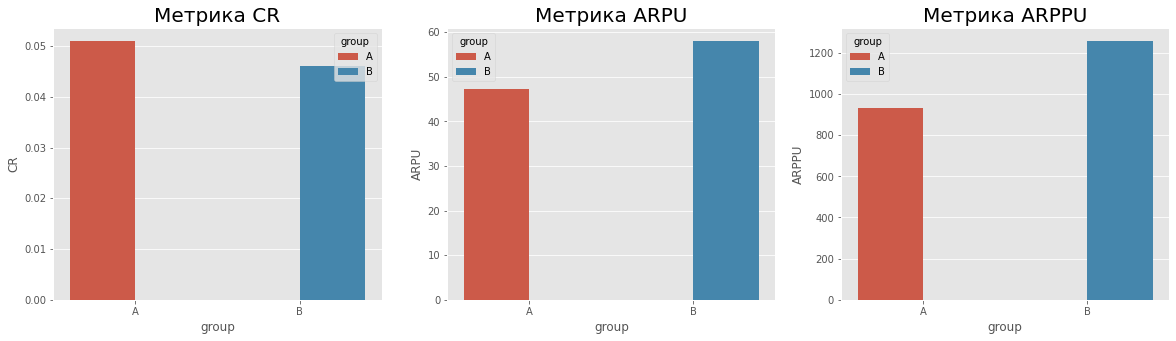

In [53]:
get_plot(metrix)

Таким образом, мы получили две функции:
1. Функция, которая подгружает доп. данные к первоначальным и считает метрики CR, ARPU, ARPPU.
2. Функция, которая строит графики по метрикам, полученным в ходе работы функции 1. <br>
Несколько нажатий кнопки позволяет подгрузить доп. файл, рассчитать метрики и посмотреть их на barplot.

<hr>

# Общий вывод:

Данный вариант проекта был посвящен A/B тестированию, SQL и Python. Подведем итог:<p>
<li> В ходе A/B тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Были расчитаны метрики CR, ARPU, ARPPU и проверена статистическая значимость рассмотренных метрик методом bootstrap. В результате теста был сделан вывод о том, что изменения в метриках при введении новой механики не были слишком сильно выражены, но с учетом положительной тенденции ARPU и ARPPU (подтвержденной bootstrap) все же было решено ввести новую механику с рекомендации о дальнейшем слежением за ситуацией.
<li> В блоке по SQL были написаны запросы по поиску очень усердных студентов образовательной платформы, а также при оптимизации воронки были рассчитаны метрики ARPU, ARPAU, CR в покупку, СR активного пользователя в покупку, CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике. При поиске усердных студентов были взяты данные за последний месяц. В результате были найдены все необходимые значения с использованием запросов в SQL. В запросах были использованы: группировка, агрегация, фильтрация, вложенные запросы, джойны. Запросы и их результат выведены в Jupyter Notebook из Clickhouse с помощью библиотеки pandahouse.
<li> Задача по Python представляла собой написания функции для подгрузки данных и расчета метрик(get_update), а также функции по построению графиков по метрикам(get_plot). Подгрузка дополнительных данных происходила с использованием ссылки на Яндекс.Диск. Уже имеющиеся данные объединялись с подгруженными и использовались для расчета метрик CR, ARPU, ARPPU. Графики строились благодаря отдельной фукнции. Для построения был выбран barplot, как наиболее удобный вариант для сравнения групп.<p>
    
Таким образом, все задания рассмотренного проекта выполнены. По каждому заданию даны комментарии и сделаны выводы.